# Preparations

In [1]:
import torch
import torchvision
import os.path

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn import manifold
from math import exp
from torch.autograd import Variable
from my_dataset import MNIST_M
from my_dataset import ST_Dataset

%matplotlib inline
%load_ext skip_kernel_extension

In [2]:
# this function takes the numpy input image with dim 3 x height x width
def convert_to_plt(input_image):
    input_image = input_image*np.asarray([0.5,0.5,0.5]) + np.asarray([0.5,0.5,0.5])
    return input_image

In [3]:
use_gpu = torch.cuda.is_available()
print("use_gpu = " + str(use_gpu))

use_gpu = True


In [4]:
import torchvision
import torchvision.transforms as transforms

In [5]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        with torch.no_grad():
            #inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            inputs, labels = Variable(inputs), Variable(labels)
            outputs, _, _ = model(inputs)
            correct += (torch.max(outputs.data, 1)[1] == labels.data).sum().item()
            total += labels.size()[0]
    acc = correct * 1.0 / total
    return acc

## Load MNIST

In [6]:
batch_size = 128
root_dir = "./data/mnist/"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
    #transforms.Normalize((0.13066047712053577, ), (1, )),
    transforms.Lambda(lambda x: torch.cat((x, x, x), dim=0))
])

trainset = torchvision.datasets.MNIST(root_dir, train=True, transform=transform,
                                      target_transform=None, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
testset = torchvision.datasets.MNIST(root_dir, train=False, transform=transform,
                                      target_transform=None, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

The 123th image in the first 128 images in the training set:


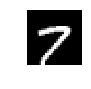

Its correspondent label:
tensor(7)


In [7]:
# randomly plot a sample from training set
import matplotlib.pyplot as plt

inputs = None
labels = None
for i, data in enumerate(trainloader):
    inputs, labels = data
    break

idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")

plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

# MNIST-M Dataset

In [8]:
from my_dataset import MNIST_M

In [9]:
batch_size = 128
root_dir = "./data/"

transform_m = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    #transforms.Normalize((0.4581609321206303, 0.462350402961343, 0.4084781187671726), (1, 1, 1))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset_m = MNIST_M(root_dir, train=True, transform=transform_m, download=True)
trainloader_m = torch.utils.data.DataLoader(trainset_m, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
testset_m = MNIST_M(root_dir, train=False, transform=transform_m, download=True)
testloader_m = torch.utils.data.DataLoader(testset_m, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

The 86th image in the first 128 images in the training set:


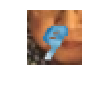

Its correspondent label:
tensor(9)


In [10]:
# randomly plot a sample from training set

inputs = None
labels = None
for i, data in enumerate(trainloader_m):
    inputs, labels = data
    break
    
idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")

plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

## Visualization

In [11]:
from sklearn import manifold

def extract_features(model, dataloader):
    features = None
    lasthidden = None
    labels = None
    for i, data in enumerate(dataloader):
        inputs, labels_ = data
        if (use_gpu):
            inputs = inputs.cuda()
        inputs = Variable(inputs)
        _, f, l = model(inputs)
        if i == 0:
            features = f
            lasthidden = l
            labels = labels_
        else:
            features = torch.cat((features, f))
            lasthidden = torch.cat((lasthidden, l))
            labels = torch.cat((labels, labels_))
    features = features.data
    lasthidden = lasthidden.data
    if use_gpu:
        features = features.cpu()
        lasthidden = lasthidden.cpu()
    return features, lasthidden, labels

def visualize_single_dataset(data, labels, perplexity=50, sample_num=None):
    total_num = labels.shape[0]
    if sample_num:
        idx = np.random.choice(total_num, sample_num, replace=False)
        data, labels = data[idx, :], labels[idx]
        total_num = sample_num
    tsne = manifold.TSNE(n_components=2, init='random',
                     random_state=0, perplexity=perplexity)
    X = tsne.fit_transform(data)
    colors = ["red", "orange", "goldenrod", "yellow", "yellowgreen", "green", "teal", "blue", "violet", "purple"]
    for i in range(10):
        plt.scatter(X[labels == i, 0], X[labels == i, 1], c=colors[i], alpha=0.4)
    plt.axis("off")
    
def visualize_da(source, target, perplexity=50, sample_num=None, save=None):
    source_num = source.shape[0]
    target_num = target.shape[0]
    if sample_num:
        source, target = source[:sample_num, :], target[:sample_num, :]
        
    data = np.vstack((source, target))

    tsne = manifold.TSNE(n_components=2, init='random',
                         random_state=0, perplexity=perplexity)
    X = tsne.fit_transform(data)
    plt.scatter(X[:sample_num, 0], X[:sample_num, 1], c="blue", edgecolors=None, alpha=0.4)
    plt.scatter(X[sample_num:, 0], X[sample_num:, 1], c="red", edgecolors=None, alpha=0.4)
    plt.axis("off")
    if save:
        plt.savefig(save)
    plt.show()
    plt.clf()
    plt.close()

In [12]:
from my_dataset import ST_Dataset

In [13]:
batch_size = 128

trainset_da = ST_Dataset(trainset, trainset_m, batch_size)
trainloader_da = torch.utils.data.DataLoader(trainset_da, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

The 127th image in the first 128 images in the training set:


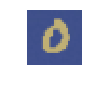

Its correspondent label:
I don't know :)

From domain:
Target


In [14]:
# randomly plot a sample from test set

inputs = None
labels = None
for i, data in enumerate(trainloader_da):
    inputs, labels, domain = data
    if i == 2:
        break

idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")
plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:")
if labels[idx].item() == -1:
    print("I don't know :)\n")
else:
    print(str(labels[idx].item()) + "\n")

print("From domain:")
if domain[idx].item() == 0:
    print("Source")
else:
    print("Target")

# WGAN Algorithm
## Definition
Define label classifier $L$ has parameter $\theta_{lc}$, domain classifier $D$ has parameter $\theta_{dc}$ and feature extractor $F$ has parameter $\theta_{fe}$  
$x_s$ is the data from source domain, while $x_t$ is the data from target domain  
$y_s$ is the label for source data  

## Loss
Loss function $L= D(F(x_t))-D(F(x_s))+L(F(x_s),y_s)$  
$D(F(x_t))$ will output 1 if it thinks input is from target, else output 0  

## Update  
$\theta_{lc}$ minimize $L(F(x_s),y_s)$  
$\theta_{dc}$ minimize $-D(F(x_t))+D(F(x_s))$  
$\theta_{fe}$ minimize $D(F(x_t))-D(F(x_s))+L(F(x_s),y_s)$  

In [15]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        # feature extractor
        self.C1 = nn.Conv2d(3, 32, 5)
        self.C2 = nn.Conv2d(32, 48, 5)

        self.C1.weight.data.normal_(0.0, 0.1)
        self.C2.weight.data.normal_(0.0, 0.1)    
        
        # label classifier
        self.LC_FC1 = nn.Linear(48 * 8 * 8, 100)
        self.LC_FC2 = nn.Linear(100, 100)
        self.LC_FC3 = nn.Linear(100, 10)
        
        self.LC_FC1.weight.data.normal_(0.0, 0.1)
        self.LC_FC2.weight.data.normal_(0.0, 0.1)
        self.LC_FC3.weight.data.normal_(0.0, 0.1)
        
        self.LC_FC1.bias.data.normal_(0.0, 0.1)
        self.LC_FC2.bias.data.normal_(0.0, 0.1)
        self.LC_FC3.bias.data.normal_(0.0, 0.1)
        
        # domain classifier
        self.DC_FC1 = nn.Linear(48 * 8 * 8, 100)
        self.DC_FC2 = nn.Linear(100, 100)
        self.DC_FC3 = nn.Linear(100, 10)
        self.DC_FC4 = nn.Linear(10, 1)
        
        self.DC_FC1.weight.data.normal_(0.0, 0.1)
        self.DC_FC2.weight.data.normal_(0.0, 0.1)
        self.DC_FC3.weight.data.normal_(0.0, 0.1)
        self.DC_FC4.weight.data.normal_(0.0, 0.1)
        
        self.DC_FC1.bias.data.normal_(0.0, 0.1)
        self.DC_FC2.bias.data.normal_(0.0, 0.1)
        self.DC_FC3.bias.data.normal_(0.0, 0.1)
        self.DC_FC4.bias.data.normal_(0.0, 0.1)        
        
    def forward(self, x):
        # C1
        x = F.relu(self.C1(x))
        # M1
        x = F.max_pool2d(x, (2, 2))
        # C2
        x = F.relu(self.C2(x))
        
        x = x.view(-1 , 48 * 8 * 8)
        
        f = x
        # label classifier
        # LC_FC1
        x_l = F.relu(self.LC_FC1(f))
        # LC_FC2
        x_l = F.relu(self.LC_FC2(x_l))
        # LC_FC3
        x_l = self.LC_FC3(x_l)

        
        # discriminator classifier
        # DC_FC1
        x_d = F.relu(self.DC_FC1(f))
        # DC_FC2
        x_d = F.relu(self.DC_FC2(x_d))
        # DC_FC3
        x_d = F.relu(self.DC_FC3(x_d))
        # DC_FC4
        x_d = self.DC_FC4(x_d)
        
        
        eps = 1e-5
        x_d = torch.clamp(x_d, min=0, max=1)
        
        return x_l, x_d
    


In [16]:
def extract_features_da(model, dataloader):
    features = None
    lasthidden = None
    labels = None
    for i, data in enumerate(dataloader):
        inputs, labels_ = data
        if (use_gpu):
            inputs = inputs.cuda()
        inputs = Variable(inputs)
        _, _, f, l = model(inputs)
        
        # from source
        if i == 0:
            features = f
            lasthidden = l
            labels = labels_
        # from target
        else:
            features = torch.cat((features, f))
            lasthidden = torch.cat((lasthidden, l))
            labels = torch.cat((labels, labels_))
    features = features.data
    lasthidden = lasthidden.data
    if use_gpu:
        features = features.cpu()
        lasthidden = lasthidden.cpu()
    return features, lasthidden, labels

### Optimizer

In [17]:
net = CNN()
if (use_gpu):
    net.cuda()
print(net)

CNN(
  (C1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (C2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (LC_FC1): Linear(in_features=3072, out_features=100, bias=True)
  (LC_FC2): Linear(in_features=100, out_features=100, bias=True)
  (LC_FC3): Linear(in_features=100, out_features=10, bias=True)
  (DC_FC1): Linear(in_features=3072, out_features=100, bias=True)
  (DC_FC2): Linear(in_features=100, out_features=100, bias=True)
  (DC_FC3): Linear(in_features=100, out_features=10, bias=True)
  (DC_FC4): Linear(in_features=10, out_features=1, bias=True)
)


In [18]:
from math import exp

lr_init = 0.001
criterion_LC = nn.CrossEntropyLoss()

params_FE =[net._modules['C1'].weight,net._modules['C1'].bias, \
            net._modules['C2'].weight,net._modules['C2'].bias]
optimizer_FE = optim.SGD(params_FE, lr=lr_init, momentum=0.9)

params_LC =[net._modules['LC_FC1'].weight,net._modules['LC_FC1'].bias, \
            net._modules['LC_FC2'].weight,net._modules['LC_FC2'].bias, \
            net._modules['LC_FC3'].weight,net._modules['LC_FC3'].bias]
optimizer_LC = optim.SGD(params_LC, lr=lr_init, momentum=0.9)

params_DC =[net._modules['DC_FC1'].weight,net._modules['DC_FC1'].bias, \
            net._modules['DC_FC2'].weight,net._modules['DC_FC2'].bias, \
            net._modules['DC_FC3'].weight,net._modules['DC_FC3'].bias, \
            net._modules['DC_FC4'].weight,net._modules['DC_FC4'].bias]
optimizer_DC = optim.SGD(params_DC, lr=lr_init, momentum=0.9)



def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr
        
def adjust_lamda(model, p):
    gamma = 10
    lamda = 2 / (1 + exp(- gamma * p)) - 1
    model.set_lamda(lamda)
    return lamda

In [19]:
para_file_da = "./parameters/DA_WGAN.pt"

load_model_da = os.path.isfile(para_file_da)

print("load_model_da = " + str(load_model_da))

load_model_da = True


In [20]:
#%%skip (not $load_model_da)
#net.load_state_dict(torch.load(para_file_da))

### Training process

In [21]:
#%%skip $load_model_da_dc


total_epoch = 25
lamda = 5


prev_loss_DC = np.float("inf")
prev_loss_LC = np.float("inf")
prev_loss_FE = np.float("inf")

for epoch in range(total_epoch):
    p = epoch * 1.0 / total_epoch

    
    print('-----------------------')
    print('Start domain classifier training')    
  
    # domain classifier 
    for DC_iter in range(1):
        epoch_loss_DC = 0.0
        running_loss_DC = 0.0
        for batch_idx, data in enumerate(trainloader_da):
        
            # get inputs
            source_size = data[0].size()[0] // 2
            inputs, labels, domains = data

            domains = domains.to(torch.float32)
            if (use_gpu):
                inputs, domains = inputs.cuda(), domains.cuda()
            inputs, domains = Variable(inputs), Variable(domains)

            # forward
            source_domain = domains[:source_size]

            target_domain = domains[-source_size:]
            
            optimizer_DC.zero_grad()
            _, pred_domains = net(inputs)
            pred_source_domain = pred_domains[:source_size]
            pred_target_domain = pred_domains[-source_size:]            
            
            # pred_source_domains should be 0 
            
            loss_DC_source = -(-torch.mean(pred_source_domain))/batch_size
            
            # pred_source_domains should be 1
            loss_DC_target = -(torch.mean(pred_target_domain))/batch_size
                
            loss_DC = loss_DC_source + loss_DC_target

            loss_DC.backward()
            optimizer_DC.step()

            # stat
            epoch_loss_DC += loss_DC.item()
            running_loss_DC += loss_DC.item()
            #print(loss_DC.cpu().data.numpy())

        print("Epoch %d DC iter %d loss: %.3f -> %.3f\n" % (epoch , DC_iter + 1, prev_loss_DC, epoch_loss_DC))
        if prev_loss_DC - epoch_loss_DC < 0.1:
            prev_loss_DC = epoch_loss_DC
            pass
        else:
            prev_loss_DC = epoch_loss_DC                

 

    print('-----------------------')
    print('Start label classifier training')
    # Label classifier
    adjust_lr(optimizer_LC, p)
    for LC_iter in range(1):
        epoch_loss_LC = 0.0
        running_loss_LC = 0.0
        for batch_idx, data in enumerate(trainloader_da):

            # get inputs
            source_size = data[0].size()[0] // 2

            inputs, labels, domains = data

            domains = domains.to(torch.float32)
            if (use_gpu):
                inputs, labels, domains = inputs.cuda(), labels.cuda(), domains.cuda()
            inputs, labels, domains = Variable(inputs), Variable(labels), Variable(domains)

            optimizer_LC.zero_grad()
            # forward
            pred_labels, _ = net(inputs)
            src_label = pred_labels[:source_size]
            loss_LC = criterion_LC(src_label, labels[:source_size])/batch_size
            loss_LC.backward()
            optimizer_LC.step()

            # stat
            epoch_loss_LC += loss_LC.item()
            running_loss_LC += loss_LC.item()

        print("Epoch %d LC iter %d loss: %.3f -> %.3f\n" % (epoch, LC_iter + 1, prev_loss_LC, epoch_loss_LC))
        if prev_loss_LC - epoch_loss_LC < 0.1:
            prev_loss_LC = epoch_loss_LC
            pass
        else:
            prev_loss_LC = epoch_loss_LC            

    
    
    print('-----------------------')
    print('Start feature extractor training')
    # feature extractor
    adjust_lr(optimizer_FE, p)
    for FE_iter in range(1):
        epoch_loss_FE = 0.0
        running_loss_FE = 0.0
        for batch_idx, data in enumerate(trainloader_da):

            # get inputs
            source_size = data[0].size()[0] // 2

            inputs, labels, domains = data

            domains = domains.to(torch.float32)
            if (use_gpu):
                inputs, labels, domains = inputs.cuda(), labels.cuda(), domains.cuda()
            inputs, labels, domains = Variable(inputs), Variable(labels), Variable(domains)

            optimizer_FE.zero_grad()
            # forward
            pred_labels, pred_domains = net(inputs)
            pred_source_domain = pred_domains[:source_size]
            pred_target_domain = pred_domains[-source_size:]
            src_label = pred_labels[:source_size]
            loss_LC = criterion_LC(src_label, labels[:source_size])/batch_size
            # pred_source_domains should be 0 
            loss_DC_source = (-torch.mean(pred_source_domain))/batch_size            
            # pred_source_domains should be 1
            loss_DC_target = (torch.mean(pred_target_domain))/batch_size  
            loss_FE = loss_LC + lamda*(loss_DC_source + loss_DC_target)
            loss_FE.backward()
            optimizer_FE.step()

            # stat
            epoch_loss_FE += loss_FE.item()
            running_loss_FE += loss_FE.item()

        print("Epoch %d LC iter %d loss: %.3f -> %.3f\n" % (epoch , FE_iter + 1, prev_loss_FE, epoch_loss_FE))
        if prev_loss_FE - epoch_loss_FE < 0.1:
            prev_loss_FE = epoch_loss_FE
            pass
        else:
            prev_loss_FE = epoch_loss_FE            
    


-----------------------
Start domain classifier training
Epoch 0 DC iter 1 loss: inf -> -0.084

-----------------------
Start label classifier training
Epoch 0 LC iter 1 loss: inf -> 21.092

-----------------------
Start feature extractor training
Epoch 0 LC iter 1 loss: inf -> 0.971

-----------------------
Start domain classifier training
Epoch 1 DC iter 1 loss: -0.084 -> 0.557

-----------------------
Start label classifier training
Epoch 1 LC iter 1 loss: 21.092 -> 10.325

-----------------------
Start feature extractor training
Epoch 1 LC iter 1 loss: 0.971 -> 8.560

-----------------------
Start domain classifier training
Epoch 2 DC iter 1 loss: 0.557 -> 0.001

-----------------------
Start label classifier training
Epoch 2 LC iter 1 loss: 10.325 -> 7.601

-----------------------
Start feature extractor training
Epoch 2 LC iter 1 loss: 8.560 -> 6.910

-----------------------
Start domain classifier training
Epoch 3 DC iter 1 loss: 0.001 -> -0.000

-----------------------
Start la

In [22]:
torch.save(net.state_dict(), para_file_da)

### Test on MNIST and MNIST-M dataset

In [23]:
def evaluate_da_accuracy(model ,dataloader, source):
    model.eval()
    correct_LC = 0
    total = 0
    
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            if (use_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = Variable(inputs, volatile = True), Variable(labels, volatile = True)

            
            outputs_LC, _ = model(inputs)
            correct_LC += (torch.max(outputs_LC.data, 1)[1] == labels.data).sum().item()

            total += labels.size()[0]
        acc_LC = correct_LC / total
    return acc_LC

In [24]:
print("Label classifier accuracy on MNIST test set (DA): %f"
      %evaluate_da_accuracy(net, testloader, source=True))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


Label classifier accuracy on MNIST test set (DA): 0.859500


In [25]:
print("Label classifier accuracy on MNIST-M test set (DA): %f\n"
      %evaluate_da_accuracy(net, testloader_m, source=True))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


Label classifier accuracy on MNIST-M test set (DA): 0.377556

